In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from cycler import cycler
import pandas as pd


# Background files and paths
background_files = [
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GJetPt20to40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GJetPt40/preselection"),
]

# Signal files and paths
signal_files = [
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X300_Y60/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X650_Y90/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X1200_Y200/preselection"),
]

data_files = [
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/Data_EraE/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/Data_EraF/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/Data_EraG/preselection"),
    
]
# Columns to be loaded
keys = ['bbgg_mass', 'dibjet_mass', 'diphoton_mass']

# Load DataFrames for background and signal
dfs_background = {}
dfs_signal = {}

for file, key in background_files:
    try:
        with uproot.open(file) as f:
            dfs_background[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

for file, key in signal_files:
    try:
        with uproot.open(file) as f:
            dfs_signal[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")
        
# Load DataFrames for data
dfs_data = {}

for file, key in data_files:
    try:
        with uproot.open(file) as f:
            dfs_data[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")


In [2]:
import pandas as pd

# Combine background DataFrames
background_data = pd.concat(dfs_background.values(), ignore_index=True)

# Combine signal DataFrames
signal_data = pd.concat(dfs_signal.values(), ignore_index=True)

# Combine data DataFrames
data = pd.concat(dfs_data.values(), ignore_index=True)


In [3]:
# Example: Splitting GGJets as resonant and GJets as non-resonant
resonant_background = dfs_background["/GGJets/preselection"]
non_resonant_background = pd.concat(
    [dfs_background["/GJetPt20to40/preselection"], dfs_background["/GJetPt40/preselection"]],
    ignore_index=True
)


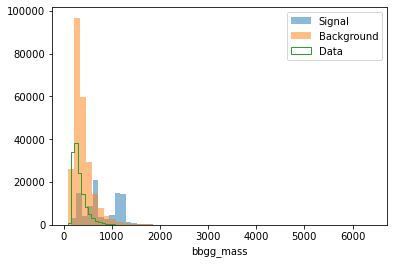

In [4]:
import matplotlib.pyplot as plt

plt.hist(signal_data['bbgg_mass'], bins=50, alpha=0.5, label='Signal')
plt.hist(background_data['bbgg_mass'], bins=50, alpha=0.5, label='Background')
plt.hist(data['bbgg_mass'], bins=50, histtype='step', label='Data')
plt.xlabel('bbgg_mass')
plt.legend()
plt.show()


In [5]:
import zfit
import tensorflow as tf

# Define variables
bbgg_mass = zfit.Space("bbgg_mass", limits=(200, 1500))  # Define range
dibjet_mass = zfit.Space("dibjet_mass", limits=(50, 300))
diphoton_mass = zfit.Space("diphoton_mass", limits=(100, 160))

# Signal model (Gaussian for simplicity)
mean_signal = zfit.Parameter("mean_signal", 1250, 1000, 1500)
sigma_signal = zfit.Parameter("sigma_signal", 50, 10, 100)
signal_pdf = zfit.pdf.Gauss(obs=bbgg_mass, mu=mean_signal, sigma=sigma_signal)

# Resonant background model
mean_res = zfit.Parameter("mean_res", 600, 500, 800)
sigma_res = zfit.Parameter("sigma_res", 100, 50, 200)
resonant_pdf = zfit.pdf.Gauss(obs=bbgg_mass, mu=mean_res, sigma=sigma_res)

# Non-resonant background model
slope = zfit.Parameter("slope", -0.01, -1, 0)
non_resonant_pdf = zfit.pdf.Exponential(obs=bbgg_mass, lam=slope)

# Combine PDFs
fraction_signal = zfit.Parameter("fraction_signal", 0.1, 0.0, 1.0)
fraction_resonant = zfit.Parameter("fraction_resonant", 0.3, 0.0, 1.0)
total_pdf = zfit.pdf.SumPDF(
    [signal_pdf, resonant_pdf, non_resonant_pdf],
    fracs=[fraction_signal, fraction_resonant]
)


/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [6]:
bbgg_mass_data = data['bbgg_mass'].to_numpy()
dataset = zfit.Data.from_numpy(obs=bbgg_mass, array=bbgg_mass_data)


In [7]:
# perform the fit
nll = zfit.loss.UnbinnedNLL(model=total_pdf, data=dataset)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)


FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, fraction_resonant, fraction_signal]] data=[<zfit.core.data.Data object at 0x7fc126d7e1f0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  False  │    True     │       True       │ 3.1e-07 │            663757.05 | -16557.54 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name                 value  (rounded)    at limit
-----------------  ------------------  ----------
fraction_signal            0.00220216       False
fraction_resonant         1.57238e-11        True
mean_signal                   1256.83       False
sigma_signal                      100    

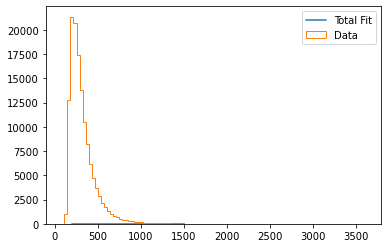

In [9]:
import numpy as np

x = np.linspace(200, 1500, 300)
y = total_pdf.pdf(x)
plt.plot(x, y, label="Total Fit")
plt.hist(bbgg_mass_data, bins=100, histtype='step', label="Data")
plt.legend()
plt.show()


In [10]:
import zfit

# Define spaces for 2D
bbgg_mass = zfit.Space("bbgg_mass", limits=(200, 1500))
dibjet_mass = zfit.Space("dibjet_mass", limits=(50, 300))
obs2D = bbgg_mass * dibjet_mass

# Define PDFs for each dimension
mean_bbgg = zfit.Parameter("mean_bbgg", 1250, 1000, 1500)
sigma_bbgg = zfit.Parameter("sigma_bbgg", 50, 10, 100)
gauss_bbgg = zfit.pdf.Gauss(obs=bbgg_mass, mu=mean_bbgg, sigma=sigma_bbgg)

mean_dibjet = zfit.Parameter("mean_dibjet", 150, 100, 200)
sigma_dibjet = zfit.Parameter("sigma_dibjet", 20, 5, 50)
gauss_dibjet = zfit.pdf.Gauss(obs=dibjet_mass, mu=mean_dibjet, sigma=sigma_dibjet)

# Combine PDFs (assume independence for now)
signal_pdf_2D = zfit.pdf.ProductPDF([gauss_bbgg, gauss_dibjet])

# Data for 2D fit
data_2D = zfit.Data.from_numpy(obs=obs2D, array=data[['bbgg_mass', 'dibjet_mass']].to_numpy())

# Fit
nll = zfit.loss.UnbinnedNLL(model=signal_pdf_2D, data=data_2D)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)


In [11]:
bbgg_mass_data = data['bbgg_mass'].to_numpy()
dataset = zfit.Data.from_numpy(obs=bbgg_mass, array=bbgg_mass_data)


In [12]:
# perform the fit
nll = zfit.loss.UnbinnedNLL(model=total_pdf, data=dataset)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
print(result)


FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_0, fraction_resonant, fraction_signal]] data=[<zfit.core.data.Data object at 0x7fc07030ceb0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  False  │    True     │       True       │ 5.2e-07 │              663739.76 |  9982.7 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name                 value  (rounded)    at limit
-----------------  ------------------  ----------
fraction_signal            0.00167442       False
fraction_resonant          0.00626497       False
mean_signal                   1319.99       False
sigma_signal                      100    

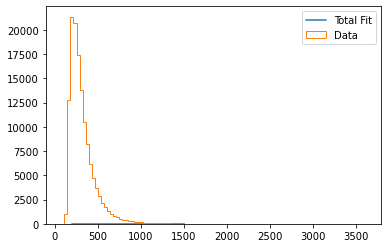

In [13]:
import numpy as np

x = np.linspace(200, 1500, 300)
y = total_pdf.pdf(x)
plt.plot(x, y, label="Total Fit")
plt.hist(bbgg_mass_data, bins=100, histtype='step', label="Data")
plt.legend()
plt.show()


# Alternative fitting methods

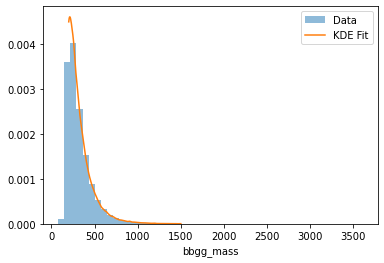

In [14]:
from sklearn.neighbors import KernelDensity
import numpy as np

# Fit KDE to bbgg_mass
kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data['bbgg_mass'].values.reshape(-1, 1))

# Generate the KDE PDF
x = np.linspace(200, 1500, 300).reshape(-1, 1)
log_density = kde.score_samples(x)  # Log of PDF
density = np.exp(log_density)

# Plot
import matplotlib.pyplot as plt
plt.hist(data['bbgg_mass'], bins=50, density=True, alpha=0.5, label='Data')
plt.plot(x, density, label='KDE Fit')
plt.xlabel('bbgg_mass')
plt.legend()
plt.show()


In [16]:
import zfit

# Define parameters for two Gaussians
mean_signal_double_gaussian = zfit.Parameter("mean_signal", 1250, 1000, 1500)
sigma1 = zfit.Parameter("sigma1", 50, 10, 100)
sigma2 = zfit.Parameter("sigma2", 100, 50, 200)
frac_gauss1 = zfit.Parameter("frac_gauss1", 0.7, 0, 1)

gauss1 = zfit.pdf.Gauss(obs=bbgg_mass, mu=mean_signal_double_gaussian, sigma=sigma1)
gauss2 = zfit.pdf.Gauss(obs=bbgg_mass, mu=mean_signal_double_gaussian, sigma=sigma2)

double_gauss = zfit.pdf.SumPDF([gauss1, gauss2], fracs=[frac_gauss1])

# Fit
nll = zfit.loss.UnbinnedNLL(model=double_gauss, data=dataset)
result = zfit.minimize.Minuit().minimize(nll)


NameAlreadyTakenError: Another parameter is already named mean_signal. Use a different, unique one.

In [17]:
from sklearn.neural_network import MLPRegressor

# Train neural network for bbgg_mass
X_signal = signal_data[['bbgg_mass']]
X_background = background_data[['bbgg_mass']]
X = pd.concat([X_signal, X_background])
y = [1] * len(X_signal) + [0] * len(X_background)

nn = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000)
nn.fit(X, y)

# Predict densities for data
data['pdf'] = nn.predict(data[['bbgg_mass']])
